In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
from moss import glm
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [13]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,4))
exp_list = ['ser','sim']

In [4]:
contrast = 'state'
roi_map = {'1':'Ains','2':'vSTR','3':'pIns','4':'V1','5':'dlpfc','6':'acc'}

#Preliminary data processing and helper functions

In [11]:
#make image for each cluster
contrast_dir = home_dir + '/analysis/ser_4mm-PEfb-diff/group/mni/' + contrast + '/'
stat_image = contrast_dir + 'zstat1_threshold_seg.nii.gz'
stat_dir = contrast_dir + 'seg/'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
for index in roi_map.keys():
    
    out_f = stat_dir + roi_map[index] + '.nii.gz'
    cmd = ['fslmaths',stat_image,'-thr',index,'-uthr',index,'-bin',out_f]
    os.system(' '.join(cmd))

In [16]:
#warp group statistical image back into subject space
for sub in sub_list: 
    #set paths
    mask_path = home_dir + '/data/' + sub
    out_dir = mask_path + '/masks/' + contrast + '/'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    #copy warpfile to make ANTs happy
    warp = mask_path + '/normalization/inverse_warpfield.nii.gz'
    warpfield = mask_path + '/normalization/InverseWarp.nii.gz'
    cmd = ['ln','-s',warp, warpfield]
    os.system(' '.join(cmd))

    for index in roi_map.keys():
        stat_image =  stat_dir + roi_map[index] + '.nii.gz'

        #warp to subject space
        out_warp = out_dir + roi_map[index] + '_anat_space.nii.gz'
        ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
        affine = home_dir + '/data/' + sub + '/normalization/affine.txt'
        anat = home_dir + '/data/' + sub + '/anat/T1_native.nii.gz'
        if not os.path.exists(out_warp):
            cmd_str = ['WarpImageMultiTransform','3',stat_image,out_warp,'-i',affine,warpfield,
                       '-R',anat]
            cmd_str = ' '.join(cmd_str)
            os.system(cmd_str)

        #register to functional space
        for exp in exp_list:
            sub_path = home_dir + 'analysis/' + exp + '_4mm/' + sub

            #register to func
            transform = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
            mean_func = sub_path + '/preproc/run_1/mean_func.nii.gz'
            out_rigid = out_dir + exp + '_' + roi_map[index] + '_func_space.nii.gz'
            if not os.path.exists(out_rigid):
                cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',out_warp,'--reg',transform,'--o',out_rigid,
                            '--no-save-reg','--inv']
                os.system(' '.join(cmd_line))

            #binarize
            out_mask = out_dir + exp + '_' + roi_map[index] + '_mask.nii.gz'
            if not os.path.exists(out_mask):
                cmd = ['fslmaths',out_rigid,'-thr','.5','-bin',out_mask]
                os.system(' '.join(cmd))


In [23]:
#extract tsnr of ROIs
def extract_cope(in_tuple):
    sub,exp,mask,contrast = in_tuple
    cope = np.nan

    cope_f = home_dir + 'analysis/' + exp + '_4mm-PEfb-diff/' + sub + \
            '/ffx/epi/smoothed/' + contrast + '/cope1.nii.gz'

    if os.path.exists(cope_f):
        
        mask_f = home_dir + 'data/' + sub + '/masks/' + contrast + '/' \
            + exp + '_' + mask + '_mask.nii.gz'
        stats = ImageStats(in_file = cope_f, op_string = '-k %s -M', mask_file = mask_f)
        out = stats.run()
        cope = out.outputs.out_stat
    
    return (sub,exp,mask,cope)

#First examine SIM/SER comparison for each ROI and the state contrast

In [24]:
contrast = 'state'
in_tuples = []
for exp in ['sim','ser']:
    for sub in sub_list:
        for index in roi_map.keys():
            in_tuples.append((sub,exp,roi_map[index],contrast))        

In [27]:
# pool = multiprocessing.Pool(processes = 40)
# output = pool.map(extract_cope,in_tuples)
# pool.terminate()
# pool.join()

In [31]:
cope_df = {'roi':[],'cope':[],'sub':[],'exp':[]}
for o in output:
    sub,exp,mask,cope = o

    out_f = 'cope_runs.csv'

    cope_df['roi'].append(mask)
    cope_df['sub'].append(sub)
    cope_df['exp'].append(exp)
    cope_df['cope'].append(cope)
    
cope_df = pd.DataFrame(cope_df)
cope_df.to_csv(home_dir + '/' + out_f)

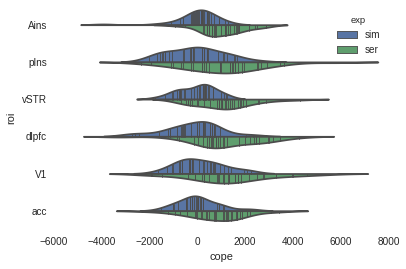

In [32]:
sns.violinplot(x='cope',y='roi',hue='exp',data=cope_df,split=True,inner = 'stick')

In [42]:
for index in roi_map.keys():
    roi = roi_map[index]
    roi_df = cope_df[cope_df['roi']==roi]
    t,p = scipy.stats.ttest_rel(roi_df.ix[roi_df['exp']=='ser','cope'].values,
                          roi_df.ix[roi_df['exp']=='sim','cope'].values)
    print roi,str(t),str(p*6)

Ains 4.71404938386 0.000292012903228
pIns 3.19931993424 0.0190226571352
vSTR 4.29922826761 0.000948043772872
dlpfc 4.76225076309 0.000254463902233
V1 3.5143576224 0.00827344773713
acc 3.66741106522 0.00547163837994


#Next look at the PE response in each of these ROIs

In [ ]:
contrast = 'PE'
in_tuples = []
for exp in ['sim','ser']:
    for sub in sub_list:
        for index in roi_map.keys():
            in_tuples.append((sub,exp,roi_map[index],contrast))        

In [ ]:
# pool = multiprocessing.Pool(processes = 40)
# output = pool.map(extract_cope,in_tuples)
# pool.terminate()
# pool.join()